##### feature set 5 chromosomes 2 to 16, inclusive 

## In this notebook:

* single input dataframe 
* using feature set 5
* random forest, n=100, balanced 

In [11]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score
from statistics import stdev

## pull in pickled dataframe:
df = pd.read_pickle("./pickled/chr2-16_set5_mc.pkl")




print("shape before", df.shape)
df = df.replace({'.': 0})  ## FIXME: atm replace with nan and drop: later find a way to impute, maybe 0 but not sure
#print("SUM", pd.isnull(df).sum())  ## Use this to see how many elements have nan 
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)
#print(df.head())

## still contains some mixed labels, see them by: df[~df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]

## Map labels to 1/0 and remove Unkn
clinvar_labels={
    'Pathogenic': 1,
    'Likely_pathogenic': 1,
    'Pathogenic/Likely_pathogenic': 1,
    'Benign/Likely_benign': 0,
    'Likely_benign': 0,
    'Benign': 0
}

#df.head()
#df = df[df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]  # best to drop everything that isn't in the dict
#df['Problematic'] = df['clinvar_clnsig'].map(clinvar_labels)

#df= df.drop(columns=['clinvar_clnsig'])#, 'clinvar_id'])  #tbh, I don't know why I kept them. consider adding to index

df = df.replace({'-': 0}) 
print("shape after dropping Unk", df.shape)
df.tail()

### pickle to reuse dataframe:
#df.to_pickle("./pickled_df/all_scores_chr18,20.pkl")


shape before (45411, 14)
shape after dropping all data with score = '.' (45411, 14)
shape after dropping Unk (45411, 14)


aapos codonpos  Polyphen2_HVAR_pred   GenoCanyon_score  \
chr pos      ref alt                                                           
16  90040357 C   T      357        1                    0  0.999702249530702   
    90040361 A   G      358        2                    0  0.999176950272567   
    90040394 G   A      369        2                    0  0.999999502550745   
    90040406 C   T      373        2                    0  0.790256222302037   
    90040498 C   T      321        1                    0   0.99985100499297   

                     LINSIGHT    RVIS_ExAC     ExAC_cnv.score  \
chr pos      ref alt                                            
16  90040357 C   T          0  1.620321912  -2.37754030564199   
    90040361 A   G          0  1.620321912  -2.37754030564199   
    90040394 G   A          0  1.620321912  -2.37754030564199   
    90040406 C   T          0  1.620321912  -2.37754030564199   
    90040498 C   T          0  1.620321912  -2.37754030564199   

                      SORVA_LOF_MAF0.005_HetOrHom  Problematic  Mutation<1kb  \
chr pos      ref alt                                                           
16  90040357 C   T                       0.001198            1             5   
    90040361 A   G                       0.001198            0             5   
    90040394 G   A                       0.001198            0             5   
    90040406 C   T                       0.001198            0             5   
    90040498 C   T                       0.001198            0             5   

                      Mutation<5kb  Mutation<10kb  Mutation<30kb  \
chr pos      ref alt                                               
16  90040357 C   T              12             17             19   
    90040361 A   G              12             17             19   
    90040394 G   A              12             17             19   
    90040406 C   T              12             17             19   
    90040498 C   T              12             17             19   

                      Mutation<100kb  
chr pos      ref alt                  
16  90040357 C   T               119  
    90040361 A   G               119  
    90040394 G   A               119  
    90040406 C   T               119  
    90040498 C   T               119

In [10]:

dfc = df.copy()
dfc = dfc.reset_index()
group_by_chr = dfc['chr'].to_numpy()
y = dfc.pop('Problematic')
X = dfc


## Extract the group-by-chromosome column:
logo = LeaveOneGroupOut()
print(logo.get_n_splits(X, y, group_by_chr))
print(logo.get_n_splits(groups = group_by_chr))

print("To split by chromosomes into %s groups" % logo.get_n_splits(groups = group_by_chr))


## Setup forest:

forest = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight='balanced')

# store results for all held out chromosomes
metric_by_test_chr = {}
all_accuracy = []
all_recall = []
all_precision = []
all_F1 = []

def get_proportion(labels):
    count = np.count_nonzero(labels == 1)
    length = len(labels)
    return {'count': count, 'length': length, 'proportion': count/length}

#### fit a model for each chromosome:

for train_index, test_index in logo.split(X, y, group_by_chr):
    #print("TRAIN:", train_index.tolist(), "TEST:", test_index.tolist())
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    test_chrom = X_test.iloc[0]['chr']
    print("Completed split for testing chromosome %s" % test_chrom) ## hah, at least I'm sure it works now 

    X_train = X_train.set_index(['chr','pos', 'ref', 'alt'])
    X_test = X_test.set_index(['chr','pos', 'ref', 'alt'])

    forest.fit(X_train, y_train)
    y_true = y_test.to_numpy()
    y_pred = forest.predict(X_test)
    
    ## Calculate metrics for each held out chr, as well as all
    print("Accuracy:", accuracy_score(y_true, y_pred))
    recall = recall_score(y_true, y_pred, average=None)[0]
    precision = precision_score(y_true, y_pred, average=None)[0]
    F1 = 2 * (precision * recall) / (precision + recall)
    
    all_accuracy.append(accuracy_score(y_true, y_pred))
    all_recall.append(recall)
    all_precision.append(precision)
    all_F1.append(F1)
    
    
    metric_by_test_chr[test_chrom] = {
        "Shape, train:": X_train.shape,
        "Shape, test:": X_test.shape,
        "Confusion matrix:": confusion_matrix(y_true, y_pred),
        "Accuracy:": accuracy_score(y_true, y_pred),
        "Recall TP/(TP+FN):": recall,
        "Precision TP/(TP+FP):": precision,
        "Proportion of Pathogenic, train": get_proportion(y_train),
        "Proportion of Pathogenic, test": get_proportion(y_test),
        "Proportion of Pathogenic, predicted": get_proportion(y_pred),
        "F1": F1
        
    }

    

15
15
To split by chromosomes into 15 groups
Completed split for testing chromosome 2
Accuracy: 0.7794970986460348
Completed split for testing chromosome 3
Accuracy: 0.8647234678624813
Completed split for testing chromosome 4
Accuracy: 0.8074110190151146
Completed split for testing chromosome 5
Accuracy: 0.8157181571815718
Completed split for testing chromosome 6
Accuracy: 0.7832093517534537
Completed split for testing chromosome 7
Accuracy: 0.8521634615384616
Completed split for testing chromosome 8
Accuracy: 0.7697147651006712
Completed split for testing chromosome 9
Accuracy: 0.831293417135296
Completed split for testing chromosome 10
Accuracy: 0.7871552079044875
Completed split for testing chromosome 11
Accuracy: 0.8674194897532413
Completed split for testing chromosome 12
Accuracy: 0.5138888888888888
Completed split for testing chromosome 13
Accuracy: 0.8823529411764706
Completed split for testing chromosome 14
Accuracy: 0.8289473684210527
Completed split for testing chromosome 15

NameError: name 'stdev' is not defined

In [21]:
## Add global metrics
def str_av_std(values):
    return str(sum(values)/len(values)) + ' +/- ' + str(stdev(values))

metric_by_test_chr['all'] = {
    "Shape, whole dataset:": X.shape,
    "Accuracy:": str_av_std(all_accuracy),
    "Recall TP/(TP+FN):": str_av_std(all_recall),
    "Precision TP/(TP+FP):": str_av_std(all_precision),
    "Proportion of Pathogenic, whole dataset": get_proportion(y),
    "F1": str_av_std(all_F1)    
}

In [22]:
import pprint as pp
pp.pprint(metric_by_test_chr)




{2: {'Accuracy:': 0.7794970986460348,
     'Confusion matrix:': array([[ 824, 1449],
       [ 261, 5221]]),
     'F1': 0.4907683144729005,
     'Precision TP/(TP+FP):': 0.759447004608295,
     'Proportion of Pathogenic, predicted': {'count': 6670,
                                             'length': 7755,
                                             'proportion': 0.8600902643455834},
     'Proportion of Pathogenic, test': {'count': 5482,
                                        'length': 7755,
                                        'proportion': 0.7068987749838813},
     'Proportion of Pathogenic, train': {'count': 26931,
                                         'length': 37656,
                                         'proportion': 0.7151848311026131},
     'Recall TP/(TP+FN):': 0.36251649802023755,
     'Shape, test:': (7755, 13),
     'Shape, train:': (37656, 13)},
 3: {'Accuracy:': 0.8647234678624813,
     'Confusion matrix:': array([[ 531,  406],
       [ 137, 2940]]),
     'F1'

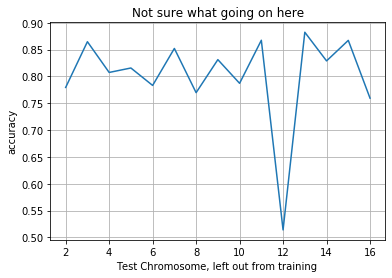

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = range(2,17)
s = all_accuracy

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='Test Chromosome, left out from training ', ylabel='accuracy',
       title='Not sure what going on here')
ax.grid()

fig.savefig("test.png")
plt.show()